In [34]:
import pandas as pd
import numpy as np
import allel
import moments.LD
import scipy.interpolate
import msprime as ms
import matplotlib.pyplot as plt
#from Windowing import *
#from Locus_selection import *

### Preprocessing of 1000G VCF files
1. Apply strict mask
    - Some sites are not reliably mapped in hg38 and need to be excluded.
    - These regions include: repeat regions, pseudogenes, centromeric, and telomeric regions.
2. Select only biallelic SNP sites
    - A VCF can contain mult-allelic SNPs and structure variants (indels, tandem repeats, etc)
    - The biallelic SNP sites are the easiest to work with, and most studies focus on them. 



This process can take quite a long time, I saved the processed VCFs under ~/projects/ctb-sgravel/data/30x1000G_biallelic_strict_masked <br>
The example preprocessing script is provided below and also in the directory's README.md.

In [ ]:
%%sh
### in bash, preprocess using bcftools
### replace variable path
chr22_vcf_path='/home/alouette/projects/ctb-sgravel/data/1000G/20201028_CCDG_14151_B01_GRM_WGS_2020-08-05_chr22.recalibrated_variants.vcf.gz'
strict_mask_1000G='/home/alouette/projects/ctb-sgravel/data/1000G/masks_and_annotations/20160622.allChr.mask.bed'
IntegerT=6
module load bcftools
bcftools --version | head -1
### -Oz output compressed VCF format
### -m2 -M2 -v to only view biallellic SNPs
### -R subset VCF from region bed file
### --threads parallelization currently only works for compression
bcftools view -i 'FILTER=="PASS"' -Oz -m2 -M2 -v snps -R ${strict_mask_1000G} ${chr22_vcf_path} --threads ${IntegerT} -o "chr22.strict_masked.vcf.gz"

bcftools manual: http://samtools.github.io/bcftools/bcftools.html#expressions

### Optional: covert the VCF to zarr format for faster retrieval in scikit-allele
In sgkit, there might be better approaches. <br>
I also completed this step and stored the output in ~/projects/ctb-sgravel/data/30x1000G_biallelic_strict_masked/zarrFormat

### Population information retrieval
1000G stored its population information in a txt file: ~/projects/ctb-sgravel/data/1000G/population_info/20130606_g1k_3202_samples_ped_population.txt <br>
This file includes family ID, sample ID, parent ID, sex, population, superpopulation. <br>
There are some family trio in 1000G data. I currently exclude the individuals information if any of their parents are also in 1000G. <br>


### Formatting the recombination map for pipeline
Several recombination maps exist for the human population. Each is computed using specific populations and with specific techniques.<br>
Two major formats exist: HapMap format and PLINK format. <br>
The main difference is how recombination rate is stored:
- HapMap: Chromosome, Position(bp), Rate(cM/Mb)
- PLINK: Chromosome, Cumulative Map(cM), Position

Recombination rate starts at 0 at the first measured SNP position, instead of starting at the first chromosome position. <br>
The current ~/projects/ctb-sgravel/data/genetic_maps contains many maps in Hg37 format. <br>
I used the HapMapII map in ~/projects/ctb-sgravel/data/genetic_maps/HapMapII_GRCh38. But transformed it into cumulative Map.

### Minimal example pipeline: EDAR region in chr2:107,500,000-110,000,000
EDAR is an identified sweep in the EAS population.

In [ ]:
%%sh
chr2_vcf_path='/home/alouette/projects/ctb-sgravel/data/1000G/20201028_CCDG_14151_B01_GRM_WGS_2020-08-05_chr2.recalibrated_variants.vcf.gz'
strict_mask_1000G='/home/alouette/projects/ctb-sgravel/data/1000G/masks_and_annotations/20160622.allChr.mask.bed'
IntegerT=6
module load bcftools
### takes 6 min
bcftools view -i 'FILTER=="PASS"' -Oz -m2 -M2 -v snps -r chr2:107500000-110000000 ${chr2_vcf_path} --threads ${IntegerT} -o "chr2.EDAR_region.vcf.gz"
bcftools index --threads ${IntegerT} "chr2.EDAR_region.vcf.gz"
### takes 3 min
bcftools view -Oz -R ${strict_mask_1000G} "chr2.EDAR_region.vcf.gz" --threads ${IntegerT} -o "chr2.EDAR_region.strict_mask.vcf.gz"

In [2]:
def read_vcf(vcf_path:str) -> dict: 
    """
    Read in the VCF using scikit-allel, the genotype information is stored in a dict
    Optimization: could limit the fields read in, can also specify detailed format like float32
    """
    callset = allel.read_vcf(vcf_path)
    return callset

In [3]:
vcf_path = "chr2.EDAR_region.strict_mask.vcf.gz"
EDAR_callset = read_vcf(vcf_path)

In [4]:
EDAR_callset

{'samples': array(['HG00096', 'HG00097', 'HG00099', ..., 'NA21142', 'NA21143',
        'NA21144'], dtype=object),
 'calldata/GT': array([[[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        ...,
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]]], dtype=int8),
 'variants/ALT': array([['G', '', ''],
        ['T', '', ''],
        ['T', '', ''],
        ...,
        ['A', '', ''],
        [

In [6]:
def msprime_read_HapMap(rec_map_path: str) -> pd.DataFrame:
    """
    Require msprime >= 1.0.0
    Read the recombination map using msprime functionality.
    Can uses the functionality: get_cumulative_mass(), find_index()
    Column 1-2, positions; left: inclusive, right: exclusive
    """
    ms_RateMap = ms.RateMap.read_hapmap(rec_map_path, position_col=1, rate_col=2)
    return ms_RateMap

In [60]:
def windowing(pos_index_list: list) -> list:
    """
    Master window function, based on the index list, give back a list of slice as windows that can be directly used with scikit_allel SNP_array.
    This function is the core function and used for other detailed window_by_* functions.
    Handles missing values, bins without any SNPs here
    :param pos_index_list: The list of position index corresponding to the starting index of each bin
    Return a list of slices
    """
    if np.all(pos_index_list == 0):
        raise ValueError("Bin position indices are all 0")
    window_list = []
    for start_index, end_index in zip(pos_index_list[:-1], pos_index_list[1:]):
        if start_index == end_index:
            ### recombination hotspot can result in no SNPs in the slice
            window_list.append(slice(None, -0))
            continue
        window_list.append(slice(start_index, end_index))
    ### next step requires loading the data, do it when in need
    return window_list

In [51]:
def window_by_reombination(pos_array: list, rec_map: ms.RateMap, rec_start: float, rec_end: float, rec_step = 0.04) -> list:
    """
    Require msprime >= 1.0.0 to use RateMap
    Call this function to get the window list separated by rec_distance
    How to handle the last position if rec subsetting is not possible?
    """
    ### end has to be larger than start
    if rec_start >= rec_end:
        raise ValueError("Input recombination range is invalid")
    ### checking if the rec_start and rec_end are contained in the given pos_array
    ### convert all positions to cumulative mass in cM from the rate map
    cum_rec_mass = rec_map.get_cumulative_mass(pos_array)* 100
    if (rec_start < np.nanmin(cum_rec_mass)) or (rec_end > np.nanmax(cum_rec_mass)):
        raise ValueError("Input recombiantion range is out of range")
    ### if given rec distance is smaller or equal to the the step 
    ### return the original array without subsetting
    if rec_end - rec_start <= rec_step:
        rec_list = [rec_start, rec_end]                    
    else:
        rec_list = np.arange(start = rec_start, stop = rec_end, step = rec_step)
        ### check the last position
        ### floating point issue, the last position can be larger than end
        if rec_list[-1] > rec_end:
            rec_list[-1] = rec_end
    ### get corresponding position index
    ### currently missing values are not considered
    pos_index_list = [np.searchsorted(cum_rec_mass, rec, side = "left") for rec in rec_list]
    ### incorporate _windowing function to create slice, and also to handle missing values later
    window_list = _windowing(pos_index_list)
    return window_list
    
    

In [6]:
pos_array = EDAR_callset['variants/POS']
snp_array = EDAR_callset['calldata/GT']
rec_map_path = "/home/alouette/projects/ctb-sgravel/data/genetic_maps/HapMapII_GRCh38/genetic_map_Hg38_chr2.txt"
ms_RateMap = msprime_read_HapMap(rec_map_path)
rec_start = ms_RateMap.get_cumulative_mass(pos_array[0])*100
rec_end = ms_RateMap.get_cumulative_mass(pos_array[-1])*100
rec_step = 0.04
window_list = window_by_reombination(pos_array, ms_RateMap, rec_start, rec_end, 0.04)

In [13]:
panel_path = "/home/alouette/projects/ctb-sgravel/alouette/1000Genome/20130606_g1k_3202_samples_ped_population.txt"
panel = read_panel(panel_path)
panel = add_callset_index(panel, EDAR_callset['samples'])
panel

,FamilyID,SampleID,FatherID,MotherID,Sex,Population,Superpopulation,callset_index
0,HG00096,HG00096,0,0,1,GBR,EUR,0
1,HG00097,HG00097,0,0,2,GBR,EUR,1
2,HG00099,HG00099,0,0,2,GBR,EUR,2
3,HG00100,HG00100,0,0,2,GBR,EUR,3
4,HG00101,HG00101,0,0,1,GBR,EUR,4
...,...,...,...,...,...,...,...,...
3197,NA21137,NA21137,0,0,2,GIH,SAS,3197
3198,NA21141,NA21141,0,0,2,GIH,SAS,3198
3199,NA21142,NA21142,0,0,2,GIH,SAS,3199
3200,NA21143,NA21143,0,0,2,GIH,SAS,3200


In [127]:
snp_window_H = allel.heterozygosity_observed(snp_window)
np.sum(snp_window_LD, axis = 1)

array([ 48.32134167,  63.60503777, 105.63581773, 192.38169577])

In [153]:
ALL_LD_list = LD_list

In [18]:
AFR_LD_list = []
EUR_LD_list = []
EAS_LD_list = []
ALL_LD_list = []
for window in window_list:
    for LD_list, super_pop in zip([AFR_LD_list, EUR_LD_list, EAS_LD_list, ALL_LD_list], ["AFR", "EUR", "EAS", ""]):
        snp_array_pop = select_by_super_population(panel, snp_array, super_pop)
        snp_window = allel.GenotypeArray(snp_array_pop[window])
        snp_window_012 = snp_window.to_n_alt(fill=-1)
        snp_window_LD = moments.LD.Parsing.compute_pairwise_stats(snp_window_012, genotypes = True)
        LD_list.append(np.sum(snp_window_LD, axis = 1))

In [37]:
ALL_H = allel.heterozygosity_observed(select_by_super_population(panel, snp_array, ""), fill = -1)
EUR_H = allel.heterozygosity_observed(select_by_super_population(panel, snp_array, "EUR"), fill = -1)
EAS_H = allel.heterozygosity_observed(select_by_super_population(panel, snp_array, "EAS"), fill = -1)
AFR_H = allel.heterozygosity_observed(select_by_super_population(panel, snp_array, "AFR"), fill = -1)

In [31]:
def LD_dataframe(LD_list: list, pos_array: list, window_list: list) -> pd.DataFrame:
    df = pd.DataFrame({"pos_start": [pos_array[window][0] for window in window_list], 
                      "pos_end": [pos_array[window][-1] for window in window_list],
                      "D2_sum": np.array(LD_list)[:, 0],
                      "Dz_sum": np.array(LD_list)[:, 1],
                      "Pi2_sum": np.array(LD_list)[:, 2],
                      "D_sum": np.array(LD_list)[:, 3]})
    df["sigD2"] = df.D2_sum/df.Pi2_sum
    df["sigDz"] = df.Dz_sum/df.Pi2_sum
    return df

In [32]:
ALL_df = LD_dataframe(ALL_LD_list, pos_array, window_list)
AFR_df = LD_dataframe(AFR_LD_list, pos_array, window_list)
EUR_df = LD_dataframe(EUR_LD_list, pos_array, window_list)
EAS_df = LD_dataframe(EAS_LD_list, pos_array, window_list)

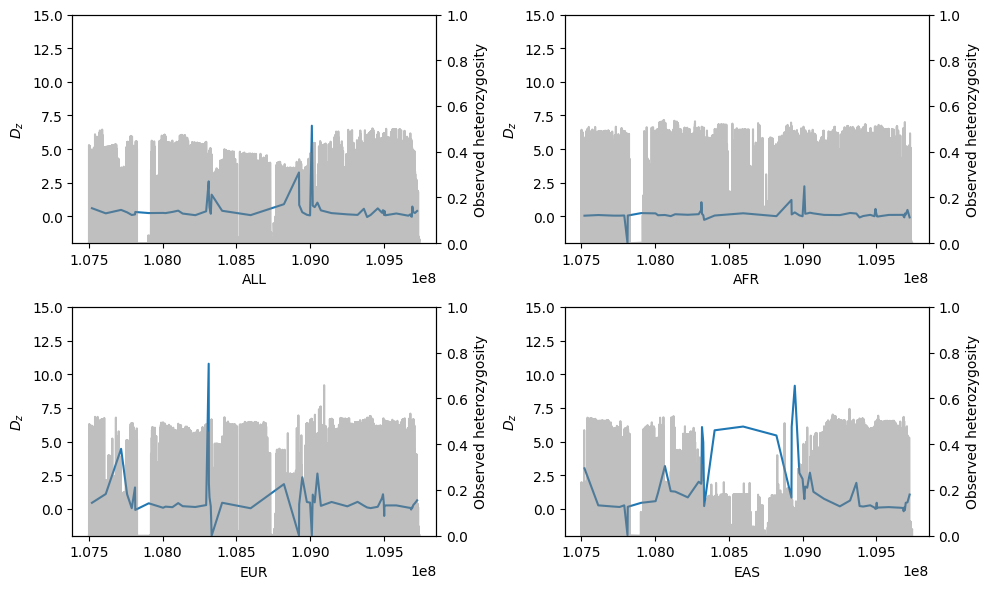

In [56]:
fig, axes = plt.subplots(2, 2, figsize = (10,6))
for df, H, label, ax in zip([ALL_df, AFR_df, EUR_df, EAS_df], [ALL_H, AFR_H, EUR_H, EAS_H], ["ALL", "AFR", "EUR", "EAS"], axes.reshape(-1)):
    ax.plot((df.pos_start + df.pos_end)/2, df.sigDz)
    ax.set_xlabel(label)
    ax2 = ax.twinx()
    ax2.plot(pos_array, H, c = "grey", alpha = 0.5)
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='y')
    ax2.set_ylabel(r'Observed heterozygosity')
    ax.set_ylim(-2, 15)
    ax.set_ylabel(r'$D_z$')
plt.tight_layout()

In [ ]:
def plot_stats(df, ax, chr, xStart, xEnd, xCol1 = "start", xCol2 = "end", stat1 = "sigDz_percentile", plotPi = False, 
               Pi = "Pi", snpPos = None, bpRange = 1e5, cMRange = 10, stat1_color = "m", Pi_color = "black", shrink = 1e6, fill = False,
              showRange = None, threshold = 10, cM_spacing = 5):
    plotDf = subset_df(df, chr, xStart, xEnd, bpRange, cMRange)
    #ax.axvspan(xStart, xEnd, alpha=0.5, fill=False, linestyle='--', color = "blue")
    ax.axvspan(snpPos, snpPos, alpha=0.5, fill=False, linestyle='--', color = "red")
    ax.set_xlabel('Genome position (MB)')
    if plotPi:
        ax2 = ax.twinx()
        ax2.plot(plotDf[xCol1], plotDf[Pi], c = Pi_color, alpha = 0.5)
        ax2.set_ylim(0, 0.008)
        ax2.tick_params(axis='y')
        ax2.set_ylabel(r'$\pi$')
    for index, row in plotDf.iterrows():
        if row["totalSNP"] < threshold:
            continue
        ax.plot([row[xCol1], row[xCol2]],[row[stat1]]*2, c = stat1_color, linewidth=2)
        if fill:
            ax.fill_between([row[xCol1], row[xCol2]],[row[stat1]]*2, facecolor = stat1_color, alpha = 0.2)
    ax_cM = ax.twiny()
    ax_cM.set_xlim(ax.get_xlim())
    ax_cM.set_xticks(plotDf.start)
    cM_label = plotDf.startCM.tolist()
    #cM_label[1:-1] = [None]*len(cM_label[1:-1])
    cM_label_new =[x if i%cM_spacing ==0 else None for i,x in enumerate(cM_label)]
    ax_cM.set_xticklabels(cM_label_new)
    ### {0:g} without trailing zero
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/shrink))
    ax.xaxis.set_major_formatter(ticks_x)
    ax.set_ylim(0, 1)
    ax_cM.set_xlabel("Rec distance (cM)", loc='right')
    if showRange is not None:
        ax.set_xlim(showRange)
        ax_cM.set_xlim(ax.get_xlim())

In [142]:
def add_callset_index(panel: pd.DataFrame, callset_sample: list):
    samples_list = list(callset_sample)
    samples_callset_index = [samples_list.index(s) for s in panel.SampleID]
    panel['callset_index'] = samples_callset_index
    return panel


In [139]:
def read_panel(panel_path:str) -> pd.DataFrame:
    panel = pd.read_csv(panel_path, sep=' ')
    return panel

In [16]:
def select_by_super_population(panel: pd.DataFrame, snp_array: list, super_population :str) -> list:
    """
    This will not affect the snp index position
    """
    if len(super_population) == 0:
        return allel.GenotypeArray(snp_array)
    loc_sample = panel[panel.Superpopulation == super_population].callset_index.values
    return snp_array.take(loc_sample, axis=1)

In [148]:
select_by_super_population(panel, snp_array, "EUR")

<GenotypeArray shape=(58860, 633, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0